# Bayesian Exploration
Here we demonstrate the use of Bayesian Exploration to characterize an unknown
function in the presence of constraints (see [here](https://www.nature.com/articles/s41467-021-25757-3)).
The function we wish to explore is the first objective of the TNK test problem.

## Specifiying generator options
We start with the generator defaults and modify as needed for conservative
exploration, which should prevent any constraint violations.

In [1]:
import pandas as pd
import torch
import yaml
from copy import deepcopy
from xopt import Xopt, Evaluator
from xopt.generators.bayesian import BayesianExplorationGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs

vocs = deepcopy(tnk_vocs)

# can only explore one objective
del vocs.objectives["y2"]

generator_options = BayesianExplorationGenerator.default_options()
generator_options.optim.num_restarts = 1
generator_options.optim.raw_samples = 100
generator_options.model.use_conservative_prior_mean = True
generator_options.model.use_conservative_prior_lengthscale = True
generator_options.model.use_low_noise_prior = True
generator_options.acq.proximal_lengthscales = [0.5, 0.5]

evaluator = Evaluator(function=evaluate_TNK)
generator = BayesianExplorationGenerator(vocs, generator_options)

print(yaml.dump(generator.options.dict()))

acq:
  monte_carlo_samples: 128
  proximal_lengthscales:
  - 0.5
  - 0.5
model:
  use_conservative_prior_lengthscale: true
  use_conservative_prior_mean: true
  use_low_noise_prior: true
n_initial: 3
optim:
  num_restarts: 1
  raw_samples: 100
  sequential: true
  use_nearby_initial_points: true



## Run exploration
We start with evaluating 2 points that we know satisfy the constraints. We then run
30 exploration steps.

In [2]:
X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)
X.submit_data(pd.DataFrame({"x1":[1.0, 0.75],"x2":[0.75, 1.0]}))

for i in range(30):
    print(f"step {i}")
    X.step()

step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29


In [3]:
# view the data
X.data

,x1,x2,y1,y2,c1,c2,some_array,xopt_error,xopt_error_str,a
1,1.000000,0.750000,1.000000,0.750000,0.626888,0.312500,"[1, 2, 3]",False,,NaN
2,0.750000,1.000000,0.750000,1.000000,0.626888,0.312500,"[1, 2, 3]",False,,NaN
3,0.913915,0.981118,0.913915,0.981118,0.713490,0.402800,"[1, 2, 3]",False,,dummy_constant
4,0.290358,0.206051,0.290358,0.206051,-0.783188,0.130355,"[1, 2, 3]",False,,dummy_constant
5,0.817346,0.736957,0.817346,0.736957,0.143436,0.156857,"[1, 2, 3]",False,,dummy_constant
6,0.676634,0.908455,0.676634,0.908455,0.351489,0.198035,"[1, 2, 3]",False,,dummy_constant
7,0.849392,0.885768,0.849392,0.885768,0.411623,0.270892,"[1, 2, 3]",False,,dummy_constant
8,1.075961,0.811947,1.075961,0.811947,0.877653,0.429043,"[1, 2, 3]",False,,dummy_constant
9,1.088288,0.816507,1.088288,0.816507,0.915234,0.446260,"[1, 2, 3]",False,,dummy_constant
10,0.994181,0.692270,0.994181,0.692270,0.562950,0.281183,"[1, 2, 3]",False,,dummy_constant


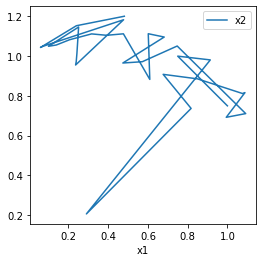

In [4]:
# plot results
ax = X.data.plot("x1", "x2")
ax.set_aspect("equal")

## Introspect models
During exploration we generate Gaussian Process models of each objective and
constraint. We demonstrate how they are viewed below.

C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


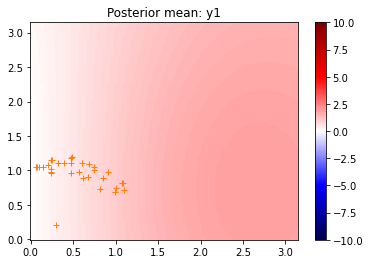

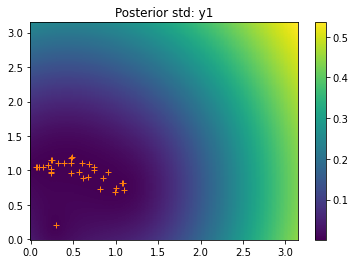

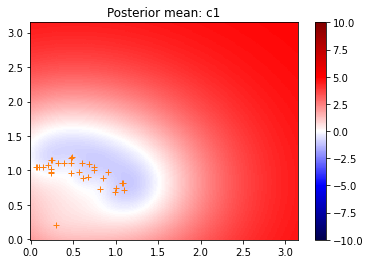

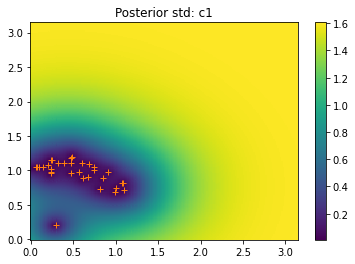

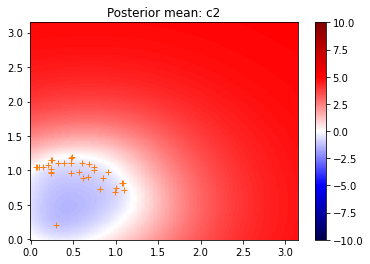

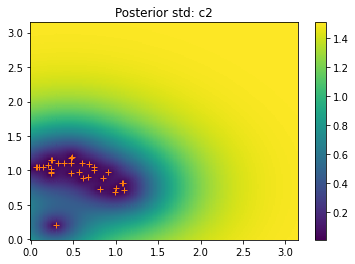

In [5]:
from matplotlib import pyplot as plt  # plot model predictions

data = X.data

bounds = generator.vocs.bounds
model = generator.train_model(generator.data)

# create mesh
n = 200
x = torch.linspace(*bounds.T[0], n)
y = torch.linspace(*bounds.T[1], n)
xx, yy = torch.meshgrid(x, y)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()

outputs = generator.vocs.output_names
with torch.no_grad():
    post = model.posterior(pts)

    mean = post.mean
    std = torch.sqrt(post.variance)

    for i in range(mean.shape[-1]):
        fig, ax = plt.subplots()
        ax.plot(*data[["x1", "x2"]].to_numpy().T, "+C1")
        c = ax.pcolor(xx, yy, mean[:, i].reshape(n, n), cmap="seismic",vmin=-10.0,
                      vmax=10.0)
        fig.colorbar(c)
        ax.set_title(f"Posterior mean: {outputs[i]}")

        fig2, ax2 = plt.subplots()
        ax2.plot(*data[["x1", "x2"]].to_numpy().T, "+C1")
        c = ax2.pcolor(xx, yy, std[:, i].reshape(n, n))
        fig2.colorbar(c)
        ax2.set_title(f"Posterior std: {outputs[i]}")

## View acquisition function and feasibility prediction

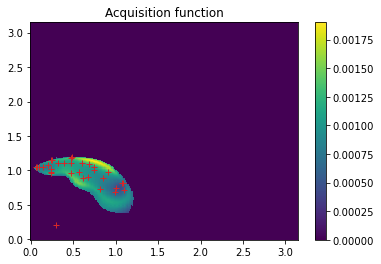

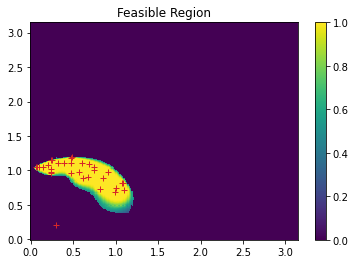

In [6]:
from xopt.generators.bayesian.utils import feasibility

acq_func = generator.get_acquisition(model)
with torch.no_grad():
    acq_pts = pts.unsqueeze(1)
    acq = acq_func(acq_pts)

    fig, ax = plt.subplots()
    c = ax.pcolor(xx, yy, acq.reshape(n, n))
    ax.plot(*data[["x1", "x2"]].to_numpy().T, "+C3")

    fig.colorbar(c)
    ax.set_title("Acquisition function")

    feas = feasibility(pts.unsqueeze(1), model, generator.sampler, vocs).flatten()

    fig2, ax2 = plt.subplots()
    c = ax2.pcolor(xx, yy, feas.reshape(n, n))
    ax2.plot(*data[["x1", "x2"]].to_numpy().T, "+C3")

    fig2.colorbar(c)
    ax2.set_title("Feasible Region")

## Generator model hyperparameters

In [7]:
# print generator model hyperparameters
for name, val in X.generator.model.named_parameters():
    print(f"{name}:{val}")

X.generator.model.models[2].covar_module.base_kernel.lengthscale

models.0.likelihood.noise_covar.raw_noise:Parameter containing:
tensor([-26.3965], dtype=torch.float64, requires_grad=True)
models.0.mean_module.constant:Parameter containing:
tensor([0.0197], dtype=torch.float64, requires_grad=True)
models.0.covar_module.raw_outputscale:5.6226805427905555
models.0.covar_module.base_kernel.raw_lengthscale:Parameter containing:
tensor([[0.2908, 0.9511]], dtype=torch.float64, requires_grad=True)
models.1.likelihood.noise_covar.raw_noise:Parameter containing:
tensor([-24.7144], dtype=torch.float64, requires_grad=True)
models.1.mean_module.constant:5.0
models.1.covar_module.raw_outputscale:2.503749377081747
models.1.covar_module.base_kernel.raw_lengthscale:Parameter containing:
tensor([[-1.1716, -1.2257]], dtype=torch.float64, requires_grad=True)
models.2.likelihood.noise_covar.raw_noise:Parameter containing:
tensor([-25.7251], dtype=torch.float64, requires_grad=True)
models.2.mean_module.constant:5.0
models.2.covar_module.raw_outputscale:2.158361458260486

tensor([[0.3009, 0.2510]], dtype=torch.float64, grad_fn=<SoftplusBackward0>)

## Examine the number of constraint violations
Using the convience function provided by the vocs object we can evaluate which
samples violate either or both of our constraints.

In [8]:
X.vocs.feasibility_data(X.data)

,feasible_c1,feasible_c2,feasible
1,True,True,True
2,True,True,True
3,True,True,True
4,False,True,False
5,True,True,True
6,True,True,True
7,True,True,True
8,True,True,True
9,True,True,True
10,True,True,True
